In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:

cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

In [6]:
with pd.HDFStore('/Volumes/My Book/Data_Analysis/Nasdaq/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [7]:
sp500_stocks.head()

,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [8]:
with pd.HDFStore('/Volumes/My Book/Data_Analysis/Nasdaq/assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

In [9]:
start = 2008
end = 2017

In [10]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2008-01-13 to 2017-12-31
Freq: W-SUN
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MPWR    521 non-null    float64
 1   COST    521 non-null    float64
 2   RL      521 non-null    float64
 3   BG      521 non-null    float64
 4   AME     521 non-null    float64
 5   GIS     521 non-null    float64
 6   CAT     521 non-null    float64
 7   SLB     521 non-null    float64
 8   ROL     521 non-null    float64
 9   BBY     521 non-null    float64
 10  EW      521 non-null    float64
 11  SWKS    521 non-null    float64
 12  ODFL    521 non-null    float64
 13  TXN     521 non-null    float64
 14  UDR     521 non-null    float64
 15  COF     521 non-null    float64
 16  NOC     521 non-null    float64
 17  KMX     521 non-null    float64
 18  EXPD    521 non-null    float64
 19  A       521 non-null    float64
 20  CB      521 non-null    float64
 21  CSGP    

In [11]:
stocks = weekly_returns.columns

In [12]:
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(25, 521)

In [13]:
NUM_PF = 100000 # no of portfolios to simulate

In [14]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

In [15]:
# Annualization Factor
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

52

In [16]:
# Compute Mean Returns, Covariance and Precision Matrix
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

In [17]:
# The precision matrix is the inverse of the covariance matrix:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

In [18]:
# Load 10 year historical risk free rate
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

In [19]:
treasury_10yr_monthly.info()
rf_rate = treasury_10yr_monthly.mean()

<class 'pandas.core.series.Series'>
DatetimeIndex: 108 entries, 2008-01-31 to 2016-12-31
Freq: M
Series name: DGS10
Non-Null Count  Dtype  
--------------  -----  
108 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [20]:
# Simulate Random Portfolios
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [21]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [22]:
df = pd.DataFrame(simul_wt)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,3.907828e-02,3.899390e-02,4.009530e-02,4.033815e-02,4.044444e-02,4.005979e-02,4.009431e-02,3.967625e-02,4.009980e-02,4.018318e-02,...,3.999340e-02,3.986154e-02,3.974735e-02,4.011072e-02,3.998130e-02,4.013811e-02,4.070582e-02,3.989081e-02,3.971451e-02,3.968391e-02
std,1.286368e-01,1.279793e-01,1.315298e-01,1.312753e-01,1.315686e-01,1.306620e-01,1.303068e-01,1.295070e-01,1.313141e-01,1.311999e-01,...,1.301607e-01,1.299232e-01,1.298244e-01,1.309389e-01,1.307060e-01,1.307771e-01,1.323300e-01,1.304945e-01,1.294478e-01,1.301086e-01
min,6.378616e-103,9.412640e-111,3.772039e-110,2.115296e-102,1.916891e-108,2.491807e-94,3.139707e-99,5.628965e-100,2.826976e-122,1.322569e-97,...,4.916482e-119,2.209908e-102,9.484009e-107,5.265857e-97,4.266959e-93,3.294735e-104,2.239585e-117,8.013765e-112,1.844493e-108,5.277121e-110
25%,5.411661e-13,6.140740e-13,6.439384e-13,5.807780e-13,6.699330e-13,8.603814e-13,8.422960e-13,8.560623e-13,6.567057e-13,6.612801e-13,...,8.560980e-13,6.892353e-13,6.217007e-13,6.183876e-13,6.231572e-13,8.368743e-13,8.873014e-13,7.562293e-13,6.981803e-13,6.144733e-13
50%,6.194838e-07,6.892727e-07,7.117295e-07,7.036265e-07,8.271366e-07,8.239578e-07,7.465119e-07,7.868799e-07,6.718880e-07,7.630554e-07,...,7.471893e-07,7.167976e-07,6.922671e-07,6.878057e-07,7.103360e-07,7.507555e-07,8.138036e-07,6.635604e-07,7.709708e-07,6.912305e-07
75%,2.138043e-03,2.307162e-03,2.432693e-03,2.389636e-03,2.582513e-03,2.415766e-03,2.342072e-03,2.419501e-03,2.382057e-03,2.469091e-03,...,2.528691e-03,2.476167e-03,2.409735e-03,2.361429e-03,2.434490e-03,2.408318e-03,2.487018e-03,2.370949e-03,2.467855e-03,2.358582e-03
max,9.995210e-01,9.987602e-01,9.988826e-01,9.974005e-01,9.993153e-01,9.990946e-01,9.996496e-01,9.992036e-01,9.978252e-01,9.994764e-01,...,9.986662e-01,9.998623e-01,9.987465e-01,9.993529e-01,9.995694e-01,9.998877e-01,9.998059e-01,9.982756e-01,9.997019e-01,9.999540e-01


Max Sharpe: 20.87%, 30.20%


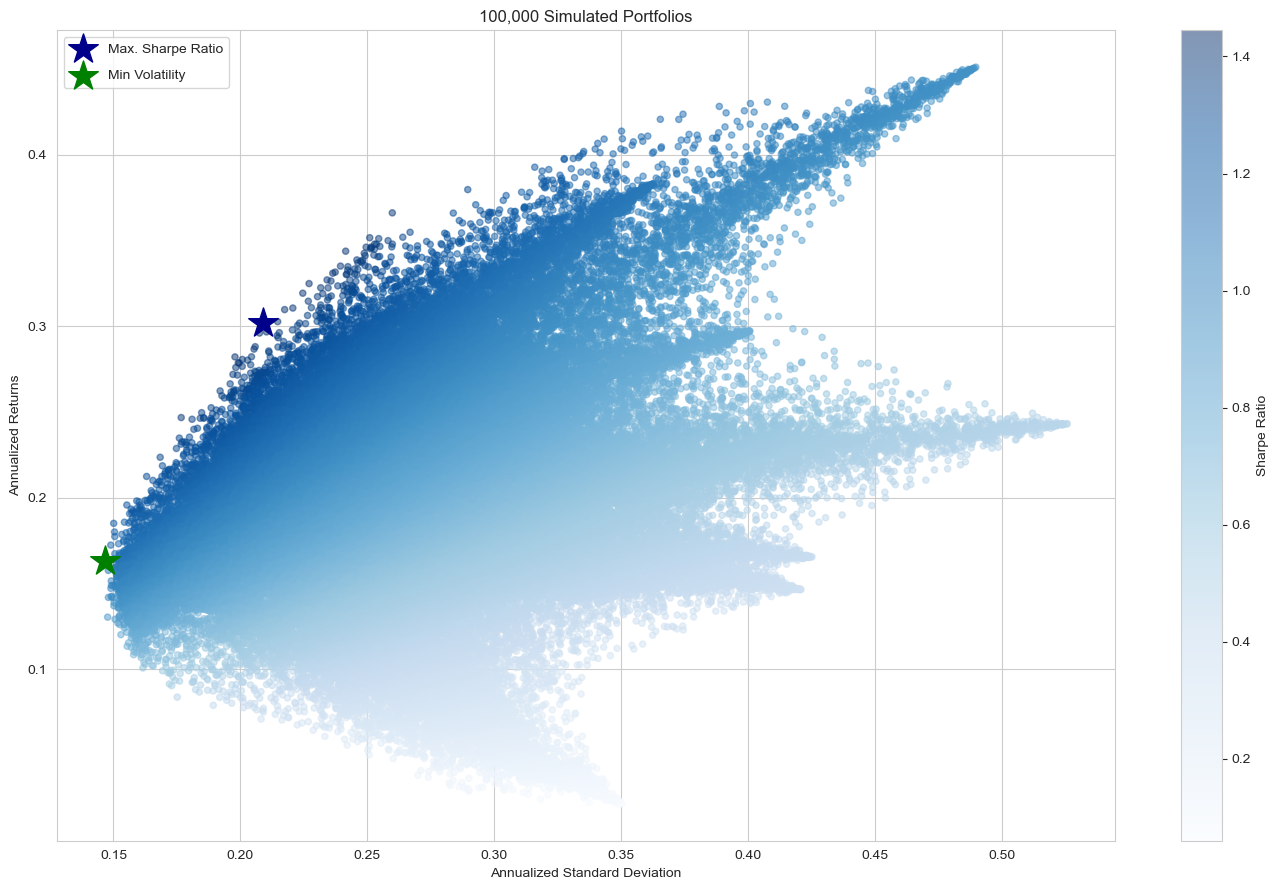

In [23]:
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

In [24]:
# Compute Annualize PF Performance
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [25]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [26]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

In [27]:
# Max Sharpe PF
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

In [28]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}

In [29]:
def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

In [30]:
# Compute Efficient Frontier
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [31]:
# Min Volatility Portfolio
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [32]:
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

In [33]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [34]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.272310            0.199882       0.752222
std                         0.060490            0.062220       0.226516
min                         0.147389            0.021377       0.059529
25%                         0.229637            0.163677       0.592198
50%                         0.263498            0.193789       0.762887
75%                         0.306727            0.231299       0.920839
max                         0.526276            0.450679       1.449856


In [35]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.212557
Annualized Returns               0.308677
Sharpe Ratio                     1.449856
Name: 84534, dtype: float64

In [36]:
# Get Max Sharpe PF
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [37]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.279221
sd     0.185042
sr     1.506261
dtype: float64

In [38]:
# Get Min Vol PF
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

In [39]:
# Get Efficent PFs
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

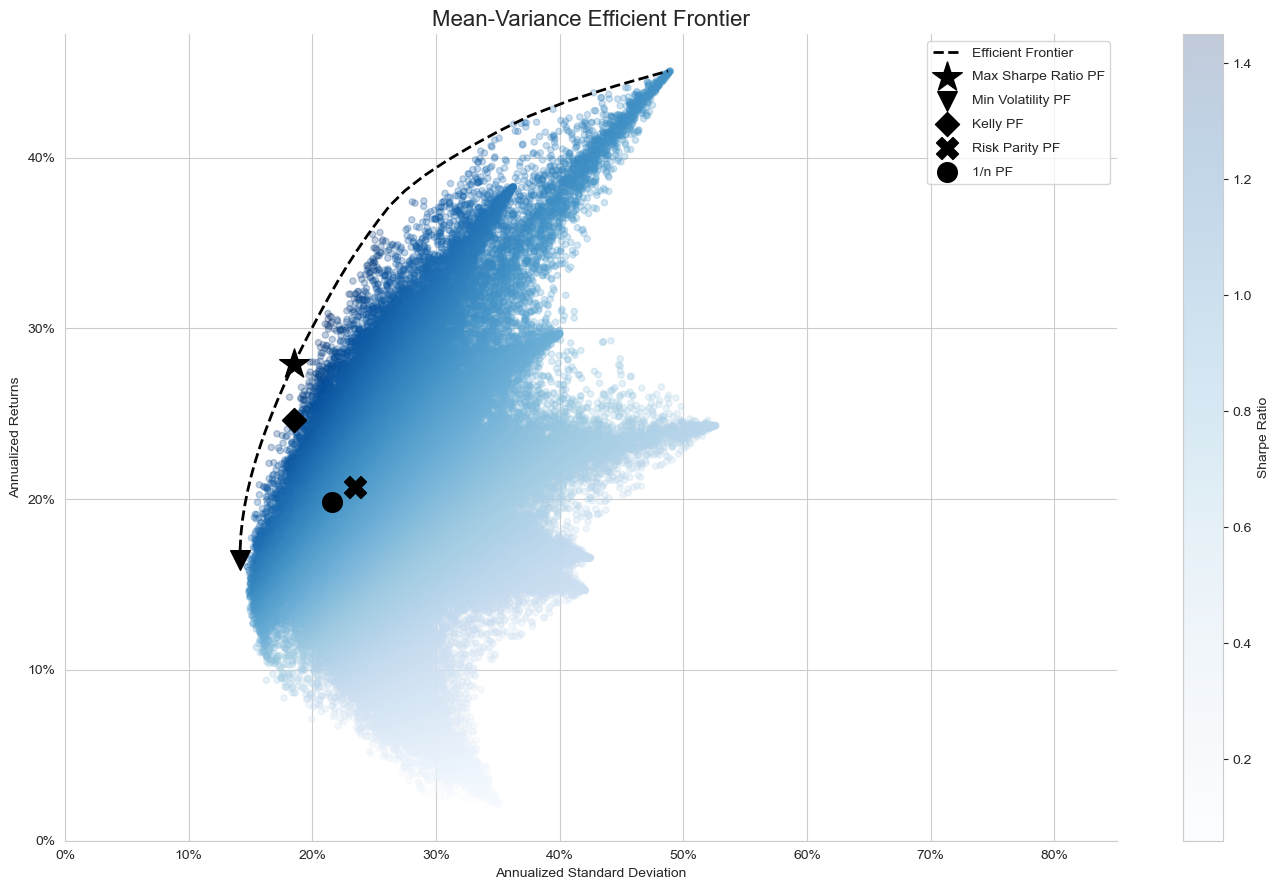

In [40]:
# Plot Result
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();